# Style Transfer with Deep Neural Networks


In this notebook, we’ll *recreate* a style transfer method that is outlined in the paper, [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) in PyTorch.

In this paper, style transfer uses the features found in the 19-layer VGG Network, which is comprised of a series of convolutional and pooling layers, and a few fully-connected layers. In the image below, the convolutional layers are named by stack and their order in the stack. Conv1_1 is the first convolutional layer that an image is passed through, in the first stack. Conv2_1 is the first convolutional layer in the *second* stack. The deepest convolutional layer in the network is conv5_4.

<img src='notebook_ims/vgg19_convlayers.png' width=80% />

### Separating Style and Content

Style transfer relies on separating the content and style of an image. Given one content image and one style image, we aim to create a new, _target_ image which should contain our desired content and style components:
* objects and their arrangement are similar to that of the **content image**
* style, colors, and textures are similar to that of the **style image**

An example is shown below, where the content image is of a cat, and the style image is of [Hokusai's Great Wave](https://en.wikipedia.org/wiki/The_Great_Wave_off_Kanagawa). The generated target image still contains the cat but is stylized with the waves, blue and beige colors, and block print textures of the style image!

<img src='notebook_ims/style_tx_cat.png' width=80% />

In this notebook, we'll use a pre-trained VGG19 Net to extract content or style features from a passed in image. We'll then formalize the idea of content and style _losses_ and use those to iteratively update our target image until we get a result that we want. You are encouraged to use a style and content image of your own and share your work on Twitter with @udacity; we'd love to see what you come up with!

In [37]:
%matplotlib inline

from torchvision import models, transforms
import torch
import cv2
from PIL import Image
import numpy as np 
from torch import optim
import matplotlib.pyplot as plt


# Using the mean and std of Imagenet is a common practice. They are calculated based on millions of images.
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

In [2]:
#load vgg features only as we don't need the classifier
vgg_features = models.vgg19(pretrained=True).features

#now freeze the parameters of vgg as we don't need to train them

for param in vgg_features.parameters():
    param.requires_grad_(False)

# if cuda is available transfer model to gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg_features.to(device)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### Load in Content and Style Images

You can load in any images you want! Below, we've provided a helper function for loading in any type and size of image. The `load_image` function also converts images to normalized Tensors.

Additionally, it will be easier to have smaller images and to squish the content and style images so that they are of the same size.

In [104]:
def load_image(img_path, max_size=400, shape=None):
    # laod image from the path
    img = Image.open(img_path).convert('RGB')
    
    # limit the size
    size = min(max_size, max(img.size))
    size = int(size*(min(img.size)/max(img.size))) # so that maximum value is size 'transforms.Resize(size)' operation
    
    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
        transforms.Resize(size), # limits the minimum value of [height, width] to size(input value)
        transforms.ToTensor(),
        transforms.Normalize(mean, std) # normalization
    ])
    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    img = in_transform(img)[:3,:,:].unsqueeze(0)

    ################### debug ################################
    # print(in_transform(img).shape)
    # print(in_transform(img)[:3,:,:].shape)
    # PIL_converter = transforms.ToPILImage()
    # transformed_image = PIL_converter(torch.squeeze(img))
    # transformed_image.show()

    return img


In [113]:
content_image = load_image('images/kahlo.jpg').to(device)
print(f'final size of content image : {content_image.shape}')

style_image = load_image('images/ben_passmore.jpg', shape=content_image.shape[-2:]).to(device)
print(f'final size of style image : {style_image.shape}')

final size of content image : torch.Size([1, 3, 333, 399])
final size of style image : torch.Size([1, 3, 333, 399])


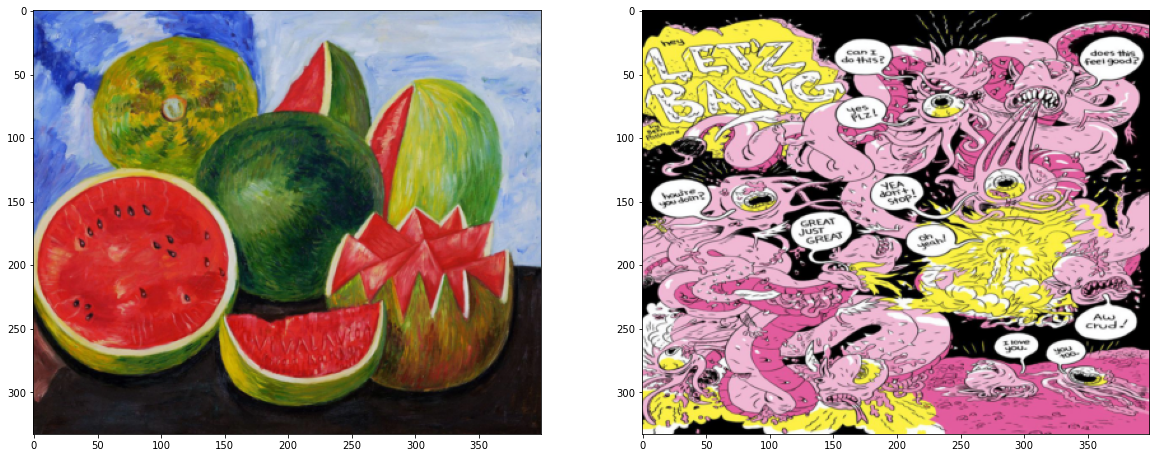

In [114]:
def convert_to_plt_image(tesor_img : torch.Tensor):
    #de normalize and convert to preferred numpy representation from tesor
    img = tesor_img.to("cpu").clone().detach()
    img = img.squeeze().numpy()
    img = img.transpose(1, 2, 0)
    img = img*np.array(std) + np.array(mean)
    img = (img*255).astype(int)
    return img

# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(convert_to_plt_image(content_image))
ax2.imshow(convert_to_plt_image(style_image))

In [107]:
print(type(vgg_features))

<class 'torch.nn.modules.container.Sequential'>


In [108]:
def get_features(image : torch.Tensor, model , layers=None) -> dict:
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """

    if layers is None:
        layers = {
            '2' : 'conv1_2',
            '7' : 'conv2_2',
            '12': 'conv3_2',
            '19': 'conv4_1',
            '21': 'conv4_2',
            '30': 'conv5_2'
        }
    
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

def gram_matrix(tensor : torch.Tensor) -> torch.Tensor:

    b, d, h, w = tensor.size()
    tensor = tensor.view(b*d, h*w)
    gram = torch.mm(tensor, tensor.transpose(0,1))
    return gram

In [116]:
# get content and style features only once before forming the target image
content_features = get_features(content_image, vgg_features)
style_features = get_features(style_image, vgg_features)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content_image.clone().requires_grad_(True).to(device)

In [117]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_2': 1.,
                 'conv2_2': 0.8,
                 'conv3_2': 0.5,
                 'conv4_2': 0.3,
                 'conv5_2': 0.1}

# you may choose to leave these as is
content_weight = 1  # alpha
style_weight = 1e6  # beta

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  688646144.0


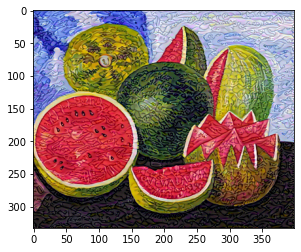

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  303878944.0


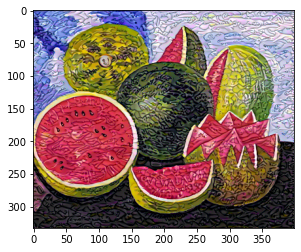

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  168397424.0


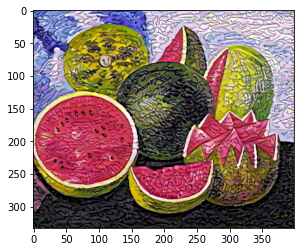

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  104852608.0


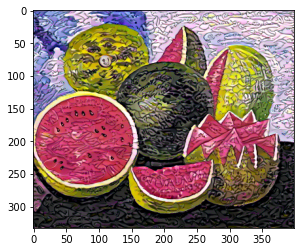

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  70872072.0


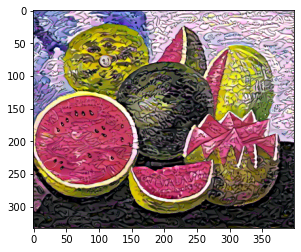

In [118]:
show_every = 400
optimizer = optim.Adam([target], lr = 0.003)
epochs = 2000

for i in range(epochs):
    print(f'working on epoch:{i+1}', end='\r')
    target_features = get_features(target, vgg_features)
    content_loss = torch.mean((target_features['conv4_2']-content_features['conv4_2'])**2)

    style_loss = 0

    for layer_name in style_weights:
        b, d, h, w = target_features[layer_name].shape
        target_gram = gram_matrix(target_features[layer_name])
        style_gram = gram_matrix(style_features[layer_name])
        layer_style_loss = style_weights[layer_name]*torch.mean((target_gram-style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)

    total_loss = content_weight*content_loss + style_weight*style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if  (i+1) % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(convert_to_plt_image(target))
        plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


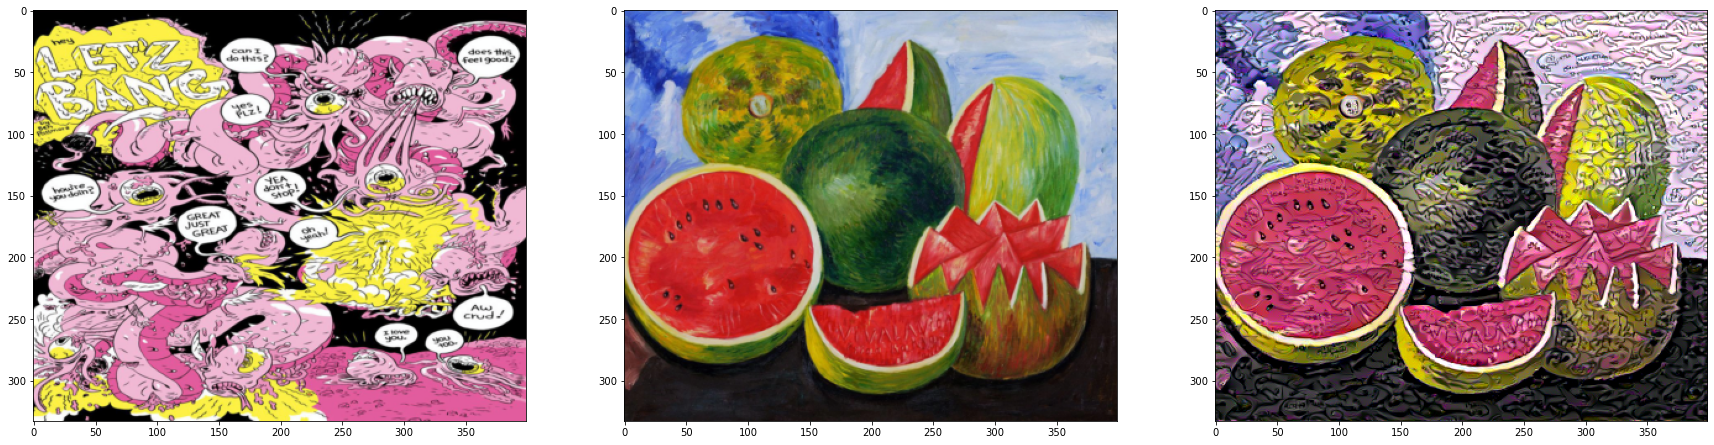

In [119]:
# display content and final, target image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
ax1.imshow(convert_to_plt_image(style_image))
ax2.imshow(convert_to_plt_image(content_image))
ax3.imshow(convert_to_plt_image(target))

In [ ]:
'''

def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """

    if layers is None:
        layers = {
            '2' : 'conv1_2',
            '7' : 'conv2_2',
            '12': 'conv3_2',
            '19': 'conv4_1',
            '21': 'conv4_2',
            '30': 'conv5_2'
        }
    
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            print(name, '***', layer)
            print(x.shape, layers[name], '*****************************************')
            
    return features
print(content_image.shape)
output = get_features(style_image, vgg_features, None)

x = output['conv1_2'].to("cpu").clone().detach()
print(x.shape)
PIL_converter = transforms.ToPILImage()
transformed_image = PIL_converter(torch.squeeze(x))
# transformed_image.show()
transformed_image.size



x = x.squeeze().numpy()
x = x[:3]
x = x.transpose(1, 2, 0)
print(x.shape)
x = x*np.array(std) + np.array(mean)
x = (x*255).astype(int)
x = x.transpose(2, 0, 1)
x = x[0]
x = x.astype(np.uint8)
print(x.shape)
print(x)


# cv2.imshow('img', x)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
scale = 10.
plt.figure( figsize=(scale, scale) )
plt.title ( 'adkjfhals' )
plt.grid  ( False )
plt.imshow( x, aspect='auto')

'''